# Candidate Selection
The candidate selection process follows the logic below, find people that meet these criteria:
1. That have a single timezone such that there are no shifts in the time series, which will distort modelling and comparison.
2. That aren't missing any of the variables used, IOB, COB, IG across the dataset.
2. That have continuous data over a broad window that can capture overnight fasting, we will set arbitrarily to 19:00-12:00.
3. Periods will then be excluded if they lack IG for an hour or later, given this may impact analysis.
4. Following this, the minimum number of nights with such data for a candidate will be set arbitrarily to 100, providing a threshold for sufficient data.


In [90]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import timedelta, time, datetime

from src.config import INTERIM_DATA_DIR
from src.configurations import Configuration, FifteenMinute
from src.helper import check_df_index, separate_flat_file
from src.candidate_selection import apply_and_filter_by_offsets, remove_null_variable_individuals

fifteen_minute = FifteenMinute()
resampled_parquet_file = INTERIM_DATA_DIR / fifteen_minute.file_name('parquet')  # Pipeline output file

config = Configuration()
# The following dtype and index setting should be fixed in the next execution of the pipeline - 2025/06/09
dtypes = {'id': int, 'iob count': int, 'cob count': int, 'bg count': int}
df_origin = pd.read_parquet(resampled_parquet_file).drop(columns='system').astype(dtypes)
df = df_origin.set_index(['id','datetime'])
df = check_df_index(df)
df.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 685122 entries, (np.int64(221634), Timestamp('2018-03-16 20:30:00')) to (np.int64(99908129), Timestamp('2018-02-01 04:45:00'))
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   iob mean   669370 non-null  Float32
 1   cob mean   644780 non-null  Float32
 2   bg mean    685122 non-null  Float32
 3   iob min    669370 non-null  Float32
 4   cob min    644780 non-null  Float32
 5   bg min     685122 non-null  Float32
 6   iob max    669370 non-null  Float32
 7   cob max    644780 non-null  Float32
 8   bg max     685122 non-null  Float32
 9   iob std    337473 non-null  Float32
 10  cob std    328312 non-null  Float32
 11  bg std     344576 non-null  Float32
 12  iob count  685122 non-null  int64  
 13  cob count  685122 non-null  int64  
 14  bg count   685122 non-null  int64  
dtype

The step will check and remove anyone that is missing all data for any of IOB, COB, BG columns, using the count columns.

In [3]:
check_cols = ['iob count', 'cob count', 'bg count']
ids_with_only_nans_or_zeros = {}
for col in check_cols:
    mask = (
        df.groupby('id')[col]
        .apply(lambda x: x.isna().all() or (x.fillna(0) == 0).all())
    )
    ids_with_only_nans_or_zeros[col] = mask[mask].index.tolist()
print(ids_with_only_nans_or_zeros)

ids = set()
for key, val in ids_with_only_nans_or_zeros.items():
    ids.update(set(val))
print(ids)

{'iob count': [], 'cob count': [49551394], 'bg count': []}
{49551394}


How many full days does each individual have? A full day is defined as having 96 15-minute intervals. The following filters based on that.

In [4]:
full_days = df.groupby('id', group_keys=False).size() // 96
mask_full_days = full_days.sort_values(ascending=False) > 100
df = df.reset_index().set_index(['id','datetime']).sort_index()
mask = df.index.get_level_values('id').isin(mask_full_days[mask_full_days].index)
print(f'People with > 100 days in the dataset: {len(df[mask].index.get_level_values("id").unique())}')

People with > 100 days in the dataset: 19


However, full days aren't what we focus on, we need to identify periods between a start time on one day and an end-time the next morning, such that we can limit the period of focus, e.g. 19:00 - 11:00. The following are functions created for this purpose. The idea being that it will split the dataset into an array of dataframes for each night for an individual, and we can then analyse the nights. Firstly, we need to separate the dataframes for individuals, then we build a class to separate and analyse the nights for an individual.


In [6]:
# This separates all dataframes for each person into an array of dataframes, making it available to iterate through, or return any individual easily.
def split_flat_file(df: pd.DataFrame) -> pd.DataFrame:
    """
    Seperates a flat file into a list of tuples, with id and df as the values.
    :param df: Dataframe of all data
    :return:
    """
    separated = []
    for group in df.groupby('id'):
        separated.append(group)
    print(f'Number of dfs: {len(separated)}')
    for i, (id_val, df) in enumerate(separated):
        df = df.reset_index().drop(columns='id').set_index('datetime')
        separated[i] = (id_val, df)
    return separated

df_tuple_by_id = split_flat_file(df)
df_individual = df_tuple_by_id[0][1]
df_individual.head()

Number of dfs: 114


,iob mean,cob mean,bg mean,iob min,cob min,bg min,iob max,cob max,bg max,iob std,cob std,bg std,iob count,cob count,bg count
datetime,,,,,,,,,,,,,,,
2018-03-16 20:30:00,1.665,0.0,138.0,1.665,0.0,138.0,1.665,0.0,138.0,<NA>,<NA>,<NA>,1,1,1
2018-03-16 21:00:00,1.04,0.932,124.0,1.04,0.932,124.0,1.04,0.932,124.0,<NA>,<NA>,<NA>,1,1,1
2018-03-16 22:00:00,0.152,0.0,139.0,0.152,0.0,139.0,0.152,0.0,139.0,<NA>,<NA>,<NA>,1,1,1
2018-03-21 16:30:00,3.541,0.0,329.0,3.384,0.0,328.0,3.697,0.0,330.0,0.221,0.0,1.414,2,2,2
2018-03-21 17:00:00,2.299,0.0,311.0,2.299,0.0,311.0,2.299,0.0,311.0,<NA>,<NA>,<NA>,1,1,1


In [66]:
import matplotlib.pyplot as plt

class Nights:
    def __init__(self, zip_id, df, night_start=time(19, 0), morning_end=time(12, 0), sample_rate = 15):
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index must be a DatetimeIndex.")
        self.zip_id = zip_id
        self.sample_rate = sample_rate
        self.df = df.sort_index()
        self.night_start = night_start
        self.morning_end = morning_end
        self.nights = self._split_nights()
        self.stats_per_night = self._create_stats_per_night()
        self.overall_stats = self._calculate_overall_stats()

    def _get_total_minutes(self):
        """
        Returns the total number of minutes between night_start and morning_end.
        """
        base_date = datetime(2000, 1, 1)
        start_dt = datetime.combine(base_date, self.night_start)
        # Handle overnight periods
        if self.morning_end <= self.night_start:
            end_dt = datetime.combine(base_date + timedelta(days=1), self.morning_end)
        else:
            end_dt = datetime.combine(base_date, self.morning_end)
        return int((end_dt - start_dt).total_seconds() // 60)

    def total_minutes(self):
        """
        Returns the number of minutes in the time period.
        """
        return self._get_total_minutes()

    def total_intervals(self):
        """
        Returns the number of intervals in the time period based on the sample rate.
        """
        return self._get_total_minutes() // self.sample_rate


    def _split_nights(self):
        """
        Split full time series dataframe for individual into separate timeseries dataframes covering each
        nightly period, based on the night_start and morning_end times.
        :return: List of dataframes, one pertaining to each night period
        """
        nights = []
        dates = pd.to_datetime(self.df.index.date)
        for date in pd.unique(dates):
            date_obj = pd.Timestamp(date).date()
            night_start_dt = pd.Timestamp.combine(date_obj, self.night_start)
            morning_end_dt = pd.Timestamp.combine(date_obj + timedelta(days=1), self.morning_end)
            mask = (self.df.index >= night_start_dt) & (self.df.index < morning_end_dt)
            night_df = self.df.loc[mask]
            if not night_df.empty:
                nights.append(night_df)

        return nights

    def remove_incomplete_nights(self):
        """
        Removes any nights that do not have a timestamp at each 15 minute interval.
        """
        complete_nights = []
        for night_df in self.nights:
            if night_df.index.nunique() == self.total_intervals:
                complete_nights.append(night_df)
        self.nights = complete_nights

    def _calculate_overall_stats(self):
        """
        Calculates stats for the overall dataset to determine the number of gaps in
        data (determined by missing intervals) to inform the level of completeness.
        :return: dict with average stats across all nights
        """
        if not self.stats_per_night:
            return print(f'No stats per night have been calculated for {self.zip_id}. Returning no output.')
        avg_num_intervals = sum(d['num_intervals'] for d in self.stats_per_night) / len(self.stats_per_night)
        avg_num_breaks = sum(d['num_breaks'] for d in self.stats_per_night) / len(self.stats_per_night)
        avg_break_length = sum(d['avg_break_length'] for d in self.stats_per_night) / len(self.stats_per_night)
        avg_max_break_length = sum(d['max_break_length'] for d in self.stats_per_night) / len(self.stats_per_night)
        avg_total_break_length = sum(d['total_break_length'] for d in self.stats_per_night) / len(self.stats_per_night)
        complete_nights =  sum(1 for d in self.stats_per_night if d['num_breaks'] == 0)

        return {
            'count_of_nights': len(self.nights),
            'complete_nights': complete_nights,
            'avg_num_intervals': avg_num_intervals,
            'avg_num_breaks': avg_num_breaks,
            'avg_break_length': avg_break_length,
            'avg_max_break_length': avg_max_break_length,
            'avg_total_break_length': avg_total_break_length,
        }

    def _create_stats_per_night(self):
        """
        Produces a dictionary of stats per night that can then be used for selection or further aggregation in overall stats.
        :return: List of dicts, one per night
        """
        stats = []
        for night_df in self.nights:
            times = night_df.index.sort_values()
            # Calculate time differences in minutes between consecutive timestamps
            diffs = times.to_series().diff().dropna().dt.total_seconds() / 60
            # A break is any gap greater than the sample rate
            breaks = diffs[diffs > self.sample_rate]
            num_intervals = len(times)
            num_breaks = len(breaks)
            avg_break_length = breaks.mean() if num_breaks > 0 else 0
            max_break_length = breaks.max() if num_breaks > 0 else 0
            total_break_length = breaks.sum() if num_breaks > 0 else 0
            stats.append({
                'num_intervals': num_intervals,
                'num_breaks': num_breaks,
                'avg_break_length': avg_break_length,
                'max_break_length': max_break_length,
                'total_break_length': total_break_length
            })

        return stats

    def plot_break_distribution(self):
        """
        Plots the total break length per night as bars (left axis) and the number of breaks as a line (right axis),
        sorted by total break length (ascending).
        """
        if not self.stats_per_night:
            print("No stats to plot.")
            return

        # Extract and sort by total break length
        stats = sorted(self.stats_per_night, key=lambda d: d["total_break_length"])
        total_break_length = [d["total_break_length"] for d in stats]
        num_breaks = [d["num_breaks"] for d in stats]

        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Bar plot for total break length (left y-axis)
        ax1.bar(range(len(total_break_length)), total_break_length, color='skyblue', label='Total Break Length')
        ax1.set_xlabel('Night (sorted by total break length)')
        ax1.set_ylabel('Total Break Length (minutes)', color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')

        # Line plot for number of breaks (right y-axis)
        ax2 = ax1.twinx()
        ax2.plot(range(len(num_breaks)), num_breaks, color='orange', marker='o', label='Number of Breaks')
        ax2.set_ylabel('Number of Breaks', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title('Break Distribution per Night (Sorted by Total Break Length)')
        fig.tight_layout()
        plt.show()

    def plot_break_histograms(self, bins=10):
        """
        Plots two separate histograms:
        1. Number of breaks per night.
        2. Total break length per night (in minutes).
        """
        if not self.stats_per_night:
            print("No stats to plot.")
            return

        num_breaks = [d["num_breaks"] for d in self.stats_per_night]
        total_break_length = [d["total_break_length"] for d in self.stats_per_night]

        # Plot histogram for number of breaks
        plt.figure(figsize=(8, 4))
        plt.hist(num_breaks, bins=bins, color='skyblue', alpha=0.8)
        plt.xlabel('Number of Breaks')
        plt.ylabel('Count (Nights)')
        plt.title('Histogram of Number of Breaks per Night')
        plt.tight_layout()
        plt.show()

        # Plot histogram for total break length
        plt.figure(figsize=(8, 4))
        plt.hist(total_break_length, bins=bins, color='orange', alpha=0.8)
        plt.xlabel('Total Break Length (minutes)')
        plt.ylabel('Count (Nights)')
        plt.title('Histogram of Total Break Lengths per Night')
        plt.tight_layout()
        plt.show()

    def plot_breaks_scatter(self):
        """
        Plots a scatter plot of number of breaks (x-axis) vs total break length (y-axis) per night.
        """
        if not self.stats_per_night:
            print("No stats to plot.")
            return

        num_breaks = [d["num_breaks"] for d in self.stats_per_night]
        total_break_length = [d["total_break_length"] for d in self.stats_per_night]

        plt.figure(figsize=(8, 5))
        plt.scatter(num_breaks, total_break_length, color='purple', alpha=0.7)
        plt.xlabel('Number of Breaks')
        plt.ylabel('Total Break Length (minutes)')
        plt.title('Scatter Plot of Breaks vs Total Break Length per Night')
        plt.tight_layout()
        plt.show()

    def get_nights(self):
        return self.nights

In [35]:
nights = Nights(df=df_individual, sample_rate=15)
print(f'Preliminarily separated nights: {len(nights.get_nights())}')
nights.remove_incomplete_nights()
print(f'Following the removal of complete nights: {len(nights.get_nights())}')

Preliminarily separated nights: 104
Following the removal of complete nights: 0


Total intervals in the night period: 68
Total minutes in the period: 1020


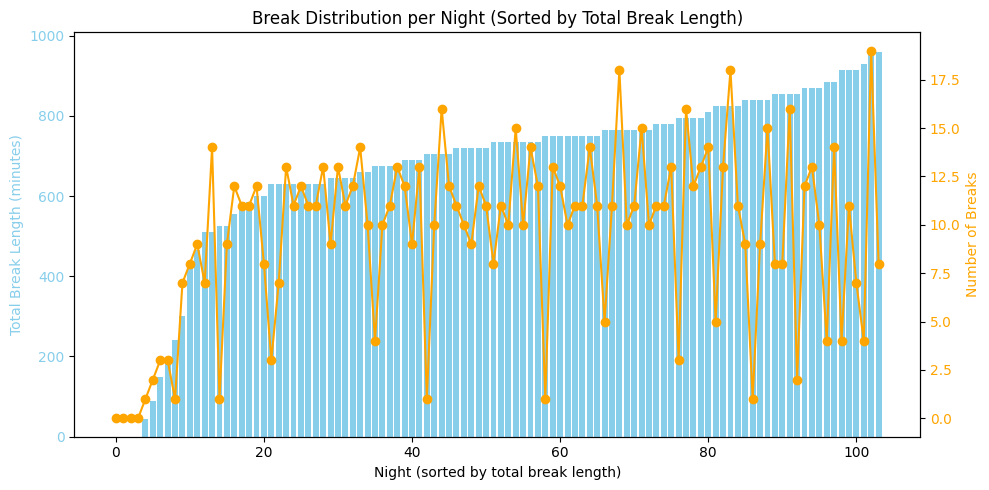

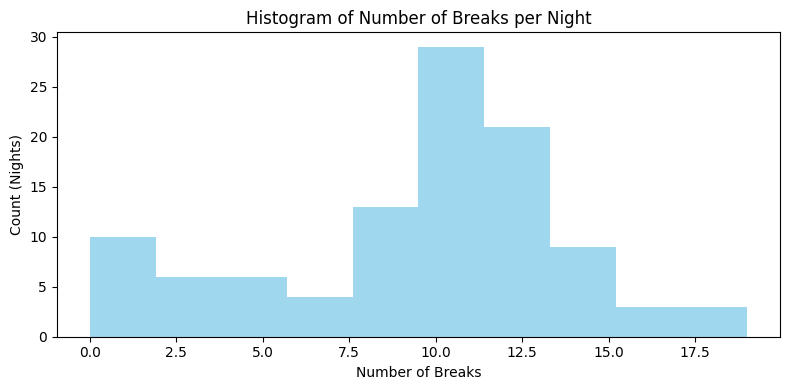

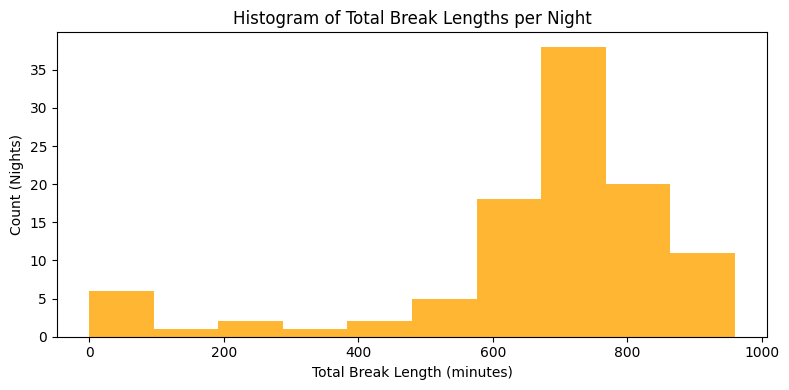

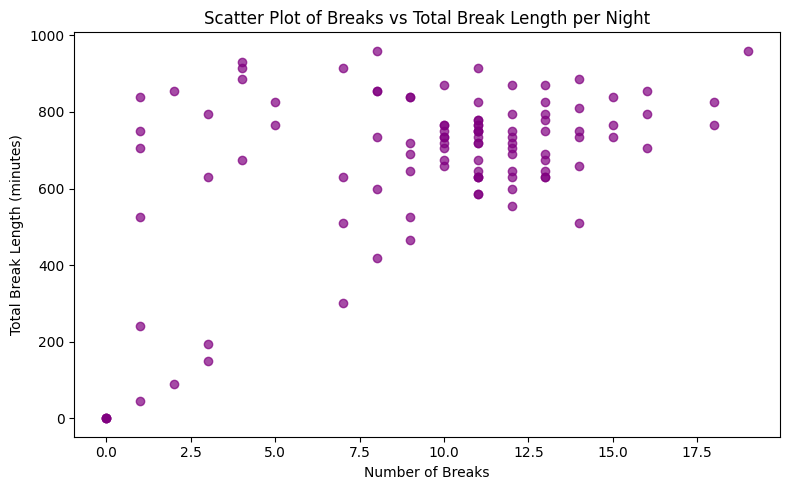

In [54]:
nights = Nights(df=df_individual, sample_rate=15)
print(f'Total intervals in the night period: {nights.total_intervals()}')
print(f'Total minutes in the period: {nights.total_minutes()}')
nights.plot_break_distribution()
nights.plot_break_histograms()
nights.plot_breaks_scatter()

Its clear with this individual that if we are concerned with the level of data over a night period and were to set an arbitrary limit of 10% loss of time covered (due to breaks in the data) then we end up with only a handful of people. Lets take a look at the whole population and see how they compare.

In [79]:
overall_stats_list = []
for id_val, df_individual in df_tuple_by_id:
    nights = Nights(zip_id=id_val, df=df_individual, sample_rate=15)
    stats = nights.overall_stats
    if stats:  # skip if stats is None
        stats['id'] = id_val
        stats['period_total_intervals'] = nights.total_intervals()
        stats['period_total_minutes'] = nights.total_minutes()
        overall_stats_list.append(stats)

df_overall_stats = pd.DataFrame(overall_stats_list)
df_overall_stats = df_overall_stats.set_index('id')
df_overall_stats.sort_values('complete_nights', ascending=False)


No stats per night have been calculated for 15634563. Returning no output.


,count_of_nights,complete_nights,avg_num_intervals,avg_num_breaks,avg_break_length,avg_max_break_length,avg_total_break_length,period_total_intervals,period_total_minutes
id,,,,,,,,,
76817975,173,58,10.791908,2.930636,141.913276,173.757225,276.763006,68,1020
26856617,109,43,1.899083,0.880734,129.747706,139.128440,174.082569,68,1020
71618088,145,35,9.937931,3.441379,84.079462,130.344828,243.827586,68,1020
49551394,261,19,26.080460,4.321839,93.214477,186.034483,334.597701,68,1020
309157,18,17,1.055556,0.055556,6.666667,6.666667,6.666667,68,1020
...,...,...,...,...,...,...,...,...,...
98974339,61,0,57.622951,6.360656,35.000195,54.590164,221.311475,68,1020
99296581,10,0,48.500000,8.900000,44.195833,105.000000,372.000000,68,1020
99712241,83,0,43.975904,5.566265,63.761976,133.734940,316.265060,68,1020


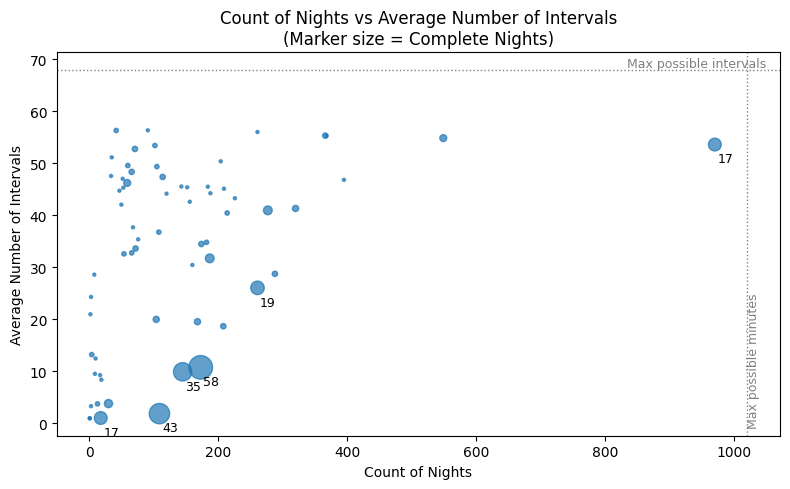

In [82]:
def plot_nights_vs_avg_intervals(df_overall_stats):
    marker_sizes = df_overall_stats['complete_nights'] * 5

    max_y = df_overall_stats['period_total_intervals'].max()
    max_x = df_overall_stats['period_total_minutes'].max()

    plt.figure(figsize=(8, 5))
    plt.scatter(
        df_overall_stats['count_of_nights'],
        df_overall_stats['avg_num_intervals'],
        s=marker_sizes,
        alpha=0.7
    )

    # Annotate points with >15 complete nights, offset to right and bottom
    for idx, row in df_overall_stats[df_overall_stats['complete_nights'] > 15].iterrows():
        plt.text(
            row['count_of_nights'] + 4,
            row['avg_num_intervals'] - 4,
            str(int(row['complete_nights'])),
            fontsize=9,
            ha='left',
            va='bottom'
        )

    # Dotted lines for max period_total_minutes (x) and period_total_intervals (y)
    plt.axhline(y=max_y, color='grey', linestyle='dotted', linewidth=1)
    plt.axvline(x=max_x, color='grey', linestyle='dotted', linewidth=1)

    # Annotate the lines
    plt.text(
        plt.xlim()[1] * 0.98, max_y,
        'Max possible intervals',
        color='grey', fontsize=9, ha='right', va='bottom'
    )
    plt.text(
        max_x, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.02,
        'Max possible minutes',
        color='grey', fontsize=9, ha='left', va='bottom', rotation=90
    )

    plt.xlabel('Count of Nights')
    plt.ylabel('Average Number of Intervals')
    plt.title('Count of Nights vs Average Number of Intervals\n(Marker size = Complete Nights)')
    plt.xlim(right=max_x * 1.05)
    plt.ylim(top=max_y * 1.05)
    plt.tight_layout()
    plt.show()

plot_nights_vs_avg_intervals(df_overall_stats)

NOTE: THE FOLLOWING COMMENT IS BASED ON THE FACT THAT THESE AREN'T YET LOCALISED:
There is a mixed picture here in terms of these different attributes that we could look to choose from. We want to maximise the number of complete nights, which can be easily determined, yet we don't want to exclude other nights that would also be useful. We really need to overlay at this point who our filtered set of people are that only have a single timezone as this will undoubtedly constrain us further.

WE NOW NEED TO LOCALISE BY OFFSETTING TIMEZONES, THEN ESTABLISH AND PLOT THE STATS ON THE SINGLE TIMEZONE SAMPLE.

So the following will be our order of processing to process the data and establish useful visualisations at each stage:
1. Import the preprocessed data
2. Apply offsets to that data
3. Remove null variable (IOB, COB, IG) individuals
4. Split the dataset (src.helper.separate_flat_file)
5. Process through the Nights class to:
    a) Separate individuals night data based on parameters
    b) Calculate stats on the individual's data completeness
6. Aggregate stats and visualise plot of individual's data

In [87]:
df_offsets = pd.read_csv(INTERIM_DATA_DIR / 'profile_offsets.csv')

df_processed = apply_and_filter_by_offsets(offsets_df=df_offsets, interim_df=df_origin)
df_processed = remove_null_variable_individuals(df_processed)
separated = separate_flat_file(df_processed)

df_overall_stats['single_tz'] = df_overall_stats.index.isin(df_offsets.index)


,count_of_nights,complete_nights,avg_num_intervals,avg_num_breaks,avg_break_length,avg_max_break_length,avg_total_break_length,period_total_intervals,period_total_minutes
id,,,,,,,,,
221634,104,4,20.019231,9.519231,102.727209,201.490385,672.259615,68,1020
309157,18,17,1.055556,0.055556,6.666667,6.666667,6.666667,68,1020
897741,45,0,52.955556,6.933333,41.007468,81.666667,280.333333,68,1020
1352464,182,2,34.835165,8.230769,59.446002,165.824176,451.813187,68,1020
2033176,3,0,31.666667,14.000000,51.877289,125.000000,730.000000,68,1020
...,...,...,...,...,...,...,...,...,...
73521474,19,0,53.105263,6.473684,35.182673,53.684211,221.842105,68,1020
74077367,368,1,55.301630,5.771739,46.043372,84.701087,245.461957,68,1020
76817975,173,58,10.791908,2.930636,141.913276,173.757225,276.763006,68,1020
